# Forecasting with sktime

In this tutorial, we implement and evaluate some of the available forecasting strategies in sktime, using both the low-level and high-level interface.

## Preliminaries

In [1]:
from sktime.forecasting.forecasters import DummyForecaster
from sktime.forecasting.forecasters import ARIMAForecaster
from sktime.forecasting.forecasters import ExpSmoothingForecaster
from sktime.forecasting.forecasters import EnsembleForecaster
from sktime.highlevel import ForecastingTask
from sktime.highlevel import ForecastingStrategy
from sktime.datasets import load_shampoo_sales

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from warnings import filterwarnings

In [2]:
filterwarnings(action='ignore', category=FutureWarning, module='statsmodels')
%matplotlib inline

## Load data

Load shampoo sales dataset from sktime containing monthly sale counts of shampoo over three years. 

In [5]:
shampoo = load_shampoo_sales()
s = shampoo.iloc[0]
s.head()

Time
1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Sales, dtype: float64

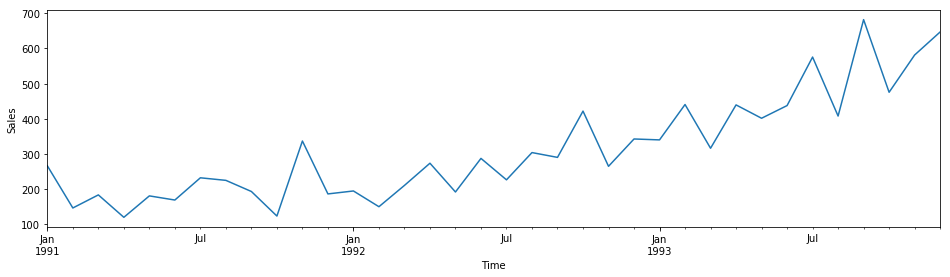

In [6]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
s.plot(ax=ax)
ax.set(ylabel=s.name);

## `sktime`  interface

### Low-level interface
* Split the data into train, test and optionally also an updated dataset
* Put the data into the expected input format, i.e. a nested pandas Series

In [8]:
# split data into train, update and test
train = pd.Series([shampoo.iloc[0].iloc[:24]])
update = pd.Series([shampoo.iloc[0].iloc[:30]])
test = pd.Series([shampoo.iloc[0].iloc[30:]])
train.iloc[0].tail()

Time
1992-08    303.6
1992-09    289.9
1992-10    421.6
1992-11    264.5
1992-12    342.3
Freq: M, Name: Sales, dtype: float64

In [9]:
# specify forecasting horizon corresponding to the test period
fh = np.arange(7, 13)
test.iloc[0]

Time
1993-07    575.5
1993-08    407.6
1993-09    682.0
1993-10    475.3
1993-11    581.3
1993-12    646.9
Freq: M, Name: Sales, dtype: float64

In [15]:
# arima model
order = (3, 2, 1)
m = ARIMAForecaster(order=order)
m.fit(train)
m.predict(fh=fh)

1993-07    360.799893
1993-08    392.708998
1993-09    378.297940
1993-10    404.737829
1993-11    393.037692
1993-12    414.144642
Freq: M, dtype: float64

In [16]:
# evaluate forecasts using default scorer (mean squared error)
m.score(test, fh=fh)

38858.2653614774

In [17]:
# update forecasts using Kalman smoothing on updated data 
#  and forecasts obtained from previously fitted model
m.update(update)
m.score(test, fh=fh)

29278.482646292516

In [18]:
# compare with fitting the model directly on the full data
m = ARIMAForecaster(order=order)
m.fit(update)
extra_periods = len(update.iloc[0]) - len(train.iloc[0])
m.score(test, fh=fh - extra_periods)

21599.616117869573

In [20]:
# simple exponential smoothing
m = ExpSmoothingForecaster()
m.fit(train)
m.score(test, fh=fh)

73025.07880629052

In [21]:
# check set params interface
m.get_params()

{'check_input': True,
 'damped': False,
 'damping_slope': None,
 'optimized': True,
 'remove_bias': False,
 'seasonal': None,
 'seasonal_periods': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_slope': None,
 'trend': None,
 'use_basinhopping': False,
 'use_boxcox': False}

In [22]:
# automatically fitted param
m._fitted_estimator.params['smoothing_level']

0.2813716099324507

In [23]:
m.set_params(**{'smoothing_level': .75})
m.fit(train)
m.score(test, fh=fh)

62204.14385878729

In [24]:
# user given fixed parameter
m._fitted_estimator.params['smoothing_level']

0.75

In [27]:
# naive 'dummy' forecaster
m = DummyForecaster(strategy='mean')
m.fit(train)
m.score(test, fh=fh)

119016.31850631906

In [29]:
# always predicts mean of time series 
m.predict(fh=fh, **{})

1993-07    229.624945
1993-08    229.624945
1993-09    229.624945
1993-10    229.624945
1993-11    229.624945
1993-12    229.624945
Freq: M, dtype: float64

In [30]:
# ensemble of forecasters
estimators = [
    ('ses', ExpSmoothingForecaster()), 
    ('holt', ExpSmoothingForecaster(trend='additive')), 
    ('damped', ExpSmoothingForecaster(trend='additive', damped=True))
]
m = EnsembleForecaster(estimators=estimators)
m.fit(train)
m.score(test, fh=fh)

58725.27105398346

### High-level interface
* Put data into expected format, i.e. nested pandas DataFrame
* Specify forecasting task 
* Use forecasting strategies

In [31]:
shampoo = load_shampoo_sales(return_dataframe=True)
train = pd.DataFrame([shampoo.iloc[0].iloc[:24]])
update = pd.DataFrame([shampoo.iloc[0].iloc[:30]])
test = pd.DataFrame([shampoo.iloc[0].iloc[30:]])

In [34]:
# create forecasting task specifying variable to be forecasted and forecasting horizon
task = ForecastingTask(target='ShampooSales', fh=[6, 7, 8], metadata=train)
task

ForecastingTask(features=Index([], dtype='object'), fh=array([6, 7, 8]),
        metadata={'nrow': 1, 'ncol': 1, 'target_type': {'ShampooSales': <class 'pandas.core.series.Series'>}, 'feature_type': {}},
        target='ShampooSales')

In [41]:
# ARIMA forecasting strategy
estimator = ARIMAForecaster(order=order)
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1994-06    737.789580
1994-07    757.827585
1994-08    778.163779
Freq: M, dtype: float64

In [42]:
# update estimator with data up to point of prediction and predict again
m.update(update)
m.predict()

1994-06    735.205498
1994-07    754.792191
1994-08    774.800131
Freq: M, dtype: float64

In [43]:
# naive forecasting strategies
estimator = DummyForecaster(strategy='mean')
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1994-06    312.600052
1994-07    312.600052
1994-08    312.600052
Freq: M, dtype: float64

In [44]:
# ensemble of forecasting strategies
estimators = [
    ('ses', ExpSmoothingForecaster()), 
    ('holt', ExpSmoothingForecaster(trend='additive')), 
    ('damped', ExpSmoothingForecaster(trend='additive', damped=True))
]
estimator = EnsembleForecaster(estimators=estimators)
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1994-06    660.155263
1994-07    669.980887
1994-08    679.759057
Freq: M, dtype: float64

In [45]:
# simple exponential smoothing strategy
estimator = ExpSmoothingForecaster()
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

1994-06    583.696428
1994-07    583.696428
1994-08    583.696428
Freq: M, dtype: float64

In [46]:
# check set params interface
m.get_params()

{'check_input': True,
 'damped': False,
 'damping_slope': None,
 'optimized': True,
 'remove_bias': False,
 'seasonal': None,
 'seasonal_periods': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_slope': None,
 'trend': None,
 'use_basinhopping': False,
 'use_boxcox': False}